# Resnet

Resnet paper: https://arxiv.org/abs/1512.03385

Goal: implement a resnet for MNIST dataset.

References:

- https://flax.readthedocs.io/en/latest/mnist_tutorial.html

## Load in the MNIST Data

In [95]:
import tensorflow_datasets as tfds
import tensorflow as tf

tf.random.set_seed(0)

train_steps = 2000
eval_every = 500
batch_size = 64

train_ds = tfds.load("mnist", split="train")
test_ds = tfds.load("mnist", split="test")

def preprocess(ds, shuffle=False):
  normalize = lambda x: { "image": tf.cast(x["image"], tf.float32) / 255., "label": x["label"] }
  ds = ds.map(normalize)
  if shuffle:
    ds = ds.repeat().shuffle(1024)
  return ds

train_ds = preprocess(train_ds, shuffle=True)
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)

test_ds = preprocess(test_ds)
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

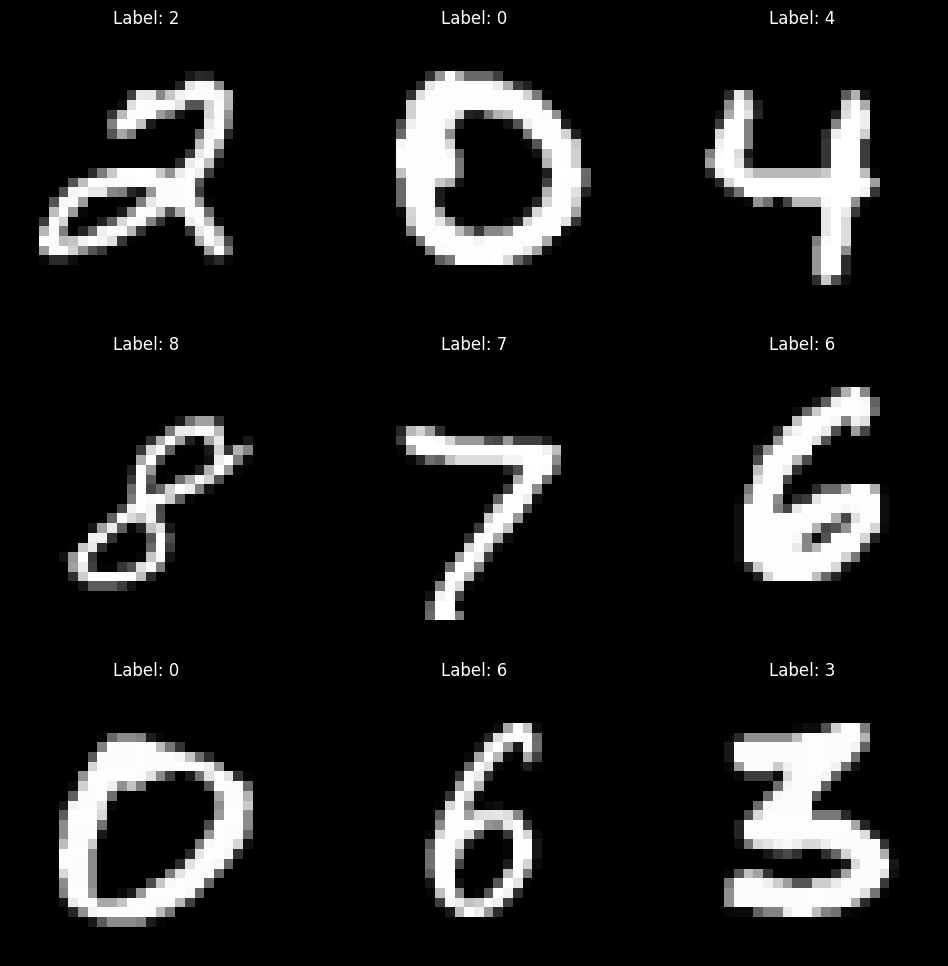

In [96]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

def view_batch(batch, rows=5, cols=5):
  fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
  for i, ax in enumerate(axs.flat):
    ax.imshow(batch["image"][i], cmap="gray")
    ax.set_title(f"Label: {batch['label'][i]}")
    ax.axis('off')



view_batch(test_ds.as_numpy_iterator().next(), rows=3, cols=3)

## The ResNet Block

In [97]:
from flax import nnx
import optax

class ResBlock(nnx.Module):
  def __init__(self, in_filters, rngs, out_filters=None):
    super().__init__()
    if out_filters is None:
      out_filters = in_filters
    diff_filters = out_filters != in_filters

    self.c0 = nnx.Conv(in_features=in_filters,
                       out_features=out_filters,
                       kernel_size=(3,3),
                       strides=2 if diff_filters else 1, # halve the H and W in the case different out_filters
                       padding="SAME",
                       rngs=rngs)
    self.bn0 = nnx.BatchNorm(out_filters, rngs=rngs)
    self.c1 = nnx.Conv(in_features=out_filters,
                      out_features=out_filters,
                      kernel_size=(3,3),
                      strides=1,
                      padding="SAME",
                      rngs=rngs)
    self.bn1 = nnx.BatchNorm(out_filters, rngs=rngs)

    #  so the shapes match up in the residual addtion f(x) + x
    if diff_filters:
      self.proj = nnx.Conv(
          in_features=in_filters,
          out_features=out_filters,
          kernel_size=(1,1),
          strides=2,
          padding="SAME",
          rngs=rngs
      )
    else:
      self.proj = lambda x: x # nothing

  def __call__(self, x):
    residual = self.proj(x)
    conv_block = lambda _input, conv2d, norm: nnx.relu(norm(conv2d(_input)))
    x = conv_block(x, self.c0, self.bn0)
    x = conv_block(x, self.c1, self.bn1)
    return x + residual


and just make sure the shapes look good

In [98]:
import jax.numpy as jnp

B = 32
H = 28
W = 28
C = 20
test_input = jnp.ones((B, H, W, C)) # (B, H, W, C)
test_input.shape

(32, 28, 28, 20)

In [99]:
b1 = ResBlock(in_filters=test_input.shape[-1], out_filters=test_input.shape[-1]*2, rngs=nnx.Rngs(0))
b1.eval()
b1(test_input).shape

(32, 14, 14, 40)

## The High Level Model

Now put together the ResNet blocks to create the entire ResNet model for my MNIST training.

In [111]:
def gen_resnet_blocks(blocks_spec, rngs):
    """Takes in an array of blocks ie: [2,2,2] where each element defines the number
    of resnet blocks and each change in element doubles the number of filters and halves the input dims.

    Returns sequential model of the resnet blocks (so you can just call as a function)
    and returns the number of filters in the last block. (the channel dim)
    """
    resnet_blocks_spec = []
    in_filters = 1
    out_filters = 1
    for j, b in enumerate(blocks_spec):
      for i in range(b):
        if i == 0 and j != 0: # for subsequent block calls double the filters
          out_filters = 2*in_filters
        resnet_blocks_spec.append(
            ResBlock(
                in_filters=in_filters,
                out_filters=out_filters,
                rngs=rngs
            )
        )
        in_filters = out_filters
    return nnx.Sequential(*resnet_blocks_spec), out_filters

class ResNetMNIST(nnx.Module):
  def __init__(self, blocks, rngs):
    super().__init__()
    self.resnet_blocks, out_filters = gen_resnet_blocks(blocks, rngs)
    self.linear = nnx.Linear(in_features=out_filters, out_features=10, rngs=rngs)

  def __call__(self, x): # x is (B, H, W, C) and in mnist (B, 28, 28, 1)
    x = self.resnet_blocks(x) # outputs (B, H_reduced, W_reduced, C_expanded)
    x = nnx.avg_pool(x, window_shape=(x.shape[1], x.shape[2])) # reduce to (B, 1, 1, C_expanded)
    x = x.reshape((x.shape[0], -1))
    x = self.linear(x)
    return x

model = ResNetMNIST(blocks=[2,2,2,2,2], rngs=nnx.Rngs(0))
model

ResNetMNIST(
  resnet_blocks=Sequential(
    layers=[ResBlock(
      c0=Conv(
        kernel_shape=(3, 3, 1, 1),
        kernel=Param(
          value=Array(shape=(3, 3, 1, 1), dtype=float32)
        ),
        bias=Param(
          value=Array([0.], dtype=float32)
        ),
        in_features=1,
        out_features=1,
        kernel_size=(3, 3),
        strides=1,
        padding='SAME',
        input_dilation=1,
        kernel_dilation=1,
        feature_group_count=1,
        use_bias=True,
        mask=None,
        dtype=None,
        param_dtype=<class 'jax.numpy.float32'>,
        precision=None,
        kernel_init=<function variance_scaling.<locals>.init at 0x7cca0431f0a0>,
        bias_init=<function zeros at 0x7cca1fcff640>,
        conv_general_dilated=<function conv_general_dilated at 0x7cca20538670>
      ),
      bn0=BatchNorm(
        mean=BatchStat(
          value=Array([0.], dtype=float32)
        ),
        var=BatchStat(
          value=Array([1.], dtype=float32

In [112]:
# test to see if we can forward pass
test_input = jnp.ones((32, 28, 28, 1))
model.eval()
model(test_input).shape

(32, 10)

## The Loss function and Optimizer

Next define how good the model is at any given point and how we can nudge the parameters in the right direction. Then in the next section we can define the training loop!

In [113]:
def loss_fn(model, batch):
  logits = model(batch["image"])
  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=batch["label"]
  ).mean() # amazing flax/optax has funcs like this
  return loss, logits

loss_fn(model, test_ds.as_numpy_iterator().next())

(Array(2.3545542, dtype=float32),
 Array([[-7.83639550e-02, -1.52498215e-01, -1.09752603e-01,
          1.55495241e-01,  3.62128973e-01, -2.35585421e-02,
         -3.31518352e-02, -3.59213114e-01,  3.12211037e-01,
          1.47408485e-01],
        [-1.05385028e-01,  6.79793060e-01,  9.94523168e-02,
         -3.76832575e-01,  4.36656147e-01, -1.81870922e-01,
         -1.52742550e-01, -9.44202393e-02,  2.93591321e-01,
          1.65938795e-01],
        [ 8.18592776e-03, -2.98929036e-01, -1.33143246e-01,
          1.32814676e-01,  4.04781252e-01, -2.79285461e-02,
          1.07533835e-01, -1.88655570e-01,  3.58140260e-01,
         -5.71255572e-02],
        [-1.38014024e-02,  4.64846730e-01,  3.42343524e-02,
         -1.68041319e-01,  3.19588155e-01, -1.24998234e-01,
         -2.44490758e-01, -1.94832146e-01,  2.09047213e-01,
          2.63589531e-01],
        [-1.58334002e-01, -2.77187347e-01, -8.59537050e-02,
         -3.23529653e-02,  4.52704400e-01,  8.58217850e-02,
          6.676166

In [114]:
learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

In [115]:
@nnx.jit
def train_step(model, opt, metrics, batch):
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])
  opt.update(grads)

@nnx.jit
def eval_step(model, metrics, batch):
  model.eval()
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])
  model.train()


In [116]:
from tqdm import tqdm

def log_metrics(history, metrics, step):
  # log train metrics
  for metric, v in metrics.compute().items():
    history[f"train_{metric}"].append(v)
  metrics.reset()

  # log the test metrics
  for test_batch in test_ds.as_numpy_iterator():
    eval_step(model, metrics, test_batch)
  for metric, value in metrics.compute().items():
    history[f"test_{metric}"].append(value)
  metrics.reset()

  print_log = lambda l: print(f"[{l}:{step}]", "loss", history[f"{l}_loss"][-1], "accuracy", history[f"{l}_accuracy"][-1]*100, "%")
  print_log("train")
  print_log("test")

history = {
    "test_loss": [],
    "train_loss": [],
    "test_accuracy": [],
    "train_accuracy": []
}

for i in range(5):
  model.train()
  for step, batch in tqdm(enumerate(train_ds.as_numpy_iterator()), total=train_steps):
    train_step(model, optimizer, metrics, batch)
    if step % eval_every == 0 and step > 0: # log every 200 after the first 200 steps
      log_metrics(history, metrics, step)

 25%|██▌       | 505/2000 [00:41<11:29,  2.17it/s]

[train:500] loss 0.48059112 accuracy 84.72118 %
[test:500] loss 1.0369031 accuracy 69.57132 %


 50%|█████     | 1005/2000 [01:14<06:42,  2.47it/s]

[train:1000] loss 0.1457573 accuracy 95.47813 %
[test:1000] loss 0.70721555 accuracy 76.96314 %


 75%|███████▌  | 1504/2000 [01:49<04:29,  1.84it/s]

[train:1500] loss 0.10831303 accuracy 96.537506 %
[test:1500] loss 0.110031046 accuracy 96.474365 %


 25%|██▌       | 505/2000 [00:39<19:02,  1.31it/s]

[train:500] loss 0.0891559 accuracy 97.14688 %
[test:500] loss 0.07917992 accuracy 97.28566 %


 50%|█████     | 1005/2000 [01:12<06:49,  2.43it/s]

[train:1000] loss 0.07967629 accuracy 97.412506 %
[test:1000] loss 0.08573564 accuracy 96.955124 %


 75%|███████▌  | 1503/2000 [01:46<03:48,  2.17it/s]

[train:1500] loss 0.07084329 accuracy 97.77501 %
[test:1500] loss 0.12478244 accuracy 95.95352 %


 25%|██▌       | 502/2000 [00:40<35:00,  1.40s/it]

[train:500] loss 0.066258356 accuracy 97.876564 %
[test:500] loss 0.05902969 accuracy 98.086945 %


 50%|█████     | 1005/2000 [01:17<08:47,  1.89it/s]

[train:1000] loss 0.062339358 accuracy 98.05626 %
[test:1000] loss 0.08826257 accuracy 97.00521 %


 75%|███████▌  | 1505/2000 [01:53<04:02,  2.04it/s]

[train:1500] loss 0.058872826 accuracy 98.12188 %
[test:1500] loss 0.07832749 accuracy 97.66627 %


 25%|██▌       | 504/2000 [00:38<11:31,  2.16it/s]

[train:500] loss 0.052679364 accuracy 98.33125 %
[test:500] loss 0.06263829 accuracy 97.89664 %


 50%|█████     | 1003/2000 [01:18<17:33,  1.06s/it]

[train:1000] loss 0.055229805 accuracy 98.22188 %
[test:1000] loss 0.056178655 accuracy 98.277245 %


 75%|███████▌  | 1504/2000 [01:55<03:24,  2.43it/s]

[train:1500] loss 0.047760796 accuracy 98.39688 %
[test:1500] loss 0.06639458 accuracy 97.92668 %


 25%|██▌       | 505/2000 [00:37<10:54,  2.29it/s]

[train:500] loss 0.047911007 accuracy 98.45157 %
[test:500] loss 0.05455035 accuracy 98.33734 %


 50%|█████     | 1003/2000 [01:13<09:24,  1.76it/s]

[train:1000] loss 0.043251477 accuracy 98.54688 %
[test:1000] loss 0.065732926 accuracy 97.91667 %


 75%|███████▌  | 1502/2000 [01:49<06:47,  1.22it/s]

[train:1500] loss 0.044592287 accuracy 98.53438 %
[test:1500] loss 0.05299938 accuracy 98.407455 %


100%|██████████| 2000/2000 [02:22<00:00, 14.04it/s]


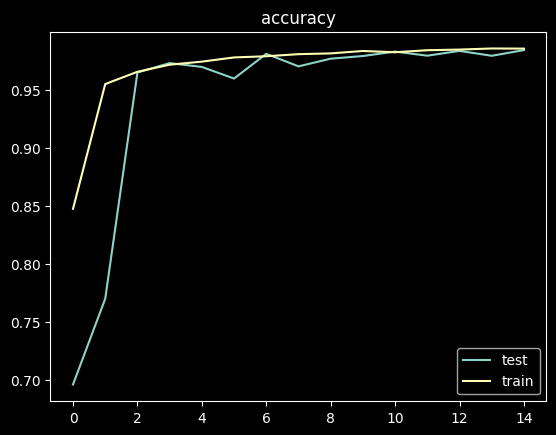

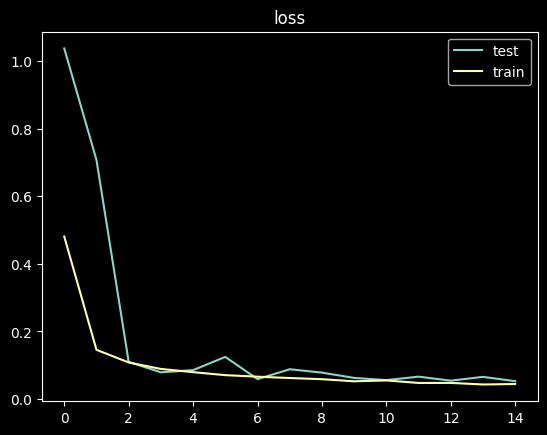

In [117]:
def plot_metrics(history, metric="loss"):
  plt.title(metric)
  plt.plot(history[f"test_{metric}"], label="test")
  plt.plot(history[f"train_{metric}"], label="train")
  plt.legend()

plot_metrics(history, "accuracy")
plt.show()
plot_metrics(history, "loss")

In [118]:
for i in range(3):
  model.train()
  for step, batch in tqdm(enumerate(train_ds.as_numpy_iterator()), total=train_steps):
    train_step(model, optimizer, metrics, batch)
    if step % eval_every == 0 and step > 0:
      log_metrics(history, metrics, step)

 25%|██▌       | 503/2000 [00:37<15:58,  1.56it/s]

[train:500] loss 0.040711563 accuracy 98.64688 %
[test:500] loss 0.06974897 accuracy 97.75641 %


 50%|█████     | 1004/2000 [01:13<08:32,  1.94it/s]

[train:1000] loss 0.040662244 accuracy 98.631256 %
[test:1000] loss 0.13461968 accuracy 95.82332 %


 75%|███████▌  | 1503/2000 [01:50<04:14,  1.95it/s]

[train:1500] loss 0.041098278 accuracy 98.59375 %
[test:1500] loss 0.05558703 accuracy 98.38742 %


 25%|██▌       | 503/2000 [00:36<15:59,  1.56it/s]

[train:500] loss 0.037071787 accuracy 98.75938 %
[test:500] loss 0.053601686 accuracy 98.467545 %


 50%|█████     | 1003/2000 [01:11<07:18,  2.28it/s]

[train:1000] loss 0.035709042 accuracy 98.79063 %
[test:1000] loss 0.062168594 accuracy 98.036865 %


 75%|███████▌  | 1505/2000 [01:46<02:57,  2.78it/s]

[train:1500] loss 0.03646947 accuracy 98.8125 %
[test:1500] loss 0.061934367 accuracy 98.3073 %


 25%|██▌       | 503/2000 [00:38<14:40,  1.70it/s]

[train:500] loss 0.03217848 accuracy 98.921875 %
[test:500] loss 0.08667254 accuracy 97.61619 %


 50%|█████     | 1003/2000 [01:14<09:44,  1.71it/s]

[train:1000] loss 0.034137957 accuracy 98.85313 %
[test:1000] loss 0.091182426 accuracy 97.395836 %


 75%|███████▌  | 1504/2000 [01:50<03:35,  2.30it/s]

[train:1500] loss 0.03442816 accuracy 98.77188 %
[test:1500] loss 0.065724775 accuracy 97.91667 %


100%|██████████| 2000/2000 [02:21<00:00, 14.08it/s]


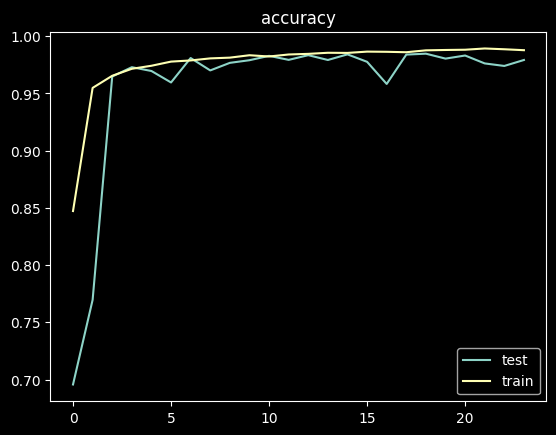

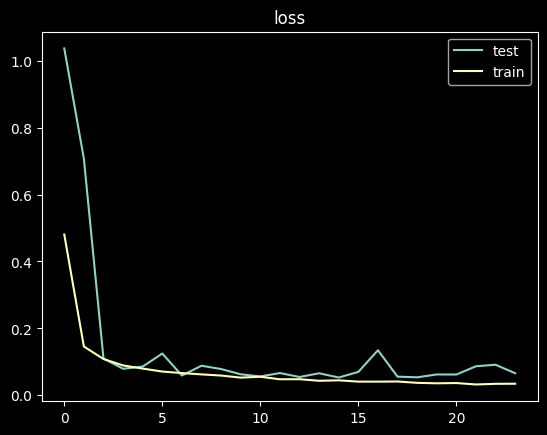

In [119]:
plot_metrics(history, "accuracy")
plt.show()
plot_metrics(history, "loss")

In [120]:
learning_rate = 0.005/10
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))

for i in range(3):
  model.train()
  for step, batch in tqdm(enumerate(train_ds.as_numpy_iterator()), total=train_steps):
    train_step(model, optimizer, metrics, batch)
    if step % eval_every == 0 and step > 0:
      log_metrics(history, metrics, step)

 25%|██▌       | 503/2000 [00:49<24:56,  1.00it/s]

[train:500] loss 0.025053792 accuracy 99.1422 %
[test:500] loss 0.040549375 accuracy 98.78806 %


 50%|█████     | 1002/2000 [01:26<13:13,  1.26it/s]

[train:1000] loss 0.014353354 accuracy 99.55 %
[test:1000] loss 0.03846422 accuracy 98.92828 %


 75%|███████▌  | 1504/2000 [02:06<06:38,  1.24it/s]

[train:1500] loss 0.014568207 accuracy 99.53126 %
[test:1500] loss 0.039083645 accuracy 98.88822 %


 25%|██▌       | 502/2000 [00:37<18:38,  1.34it/s]

[train:500] loss 0.01113944 accuracy 99.65626 %
[test:500] loss 0.040708132 accuracy 98.84816 %


 50%|█████     | 1003/2000 [01:13<09:08,  1.82it/s]

[train:1000] loss 0.010747976 accuracy 99.66563 %
[test:1000] loss 0.037741248 accuracy 98.958336 %


 75%|███████▌  | 1505/2000 [01:55<07:38,  1.08it/s]

[train:1500] loss 0.011154627 accuracy 99.625 %
[test:1500] loss 0.039982535 accuracy 98.88822 %


 25%|██▌       | 503/2000 [00:34<14:11,  1.76it/s]

[train:500] loss 0.009402739 accuracy 99.72188 %
[test:500] loss 0.040164128 accuracy 98.85817 %


 50%|█████     | 1003/2000 [01:11<09:38,  1.72it/s]

[train:1000] loss 0.009608528 accuracy 99.725 %
[test:1000] loss 0.0393445 accuracy 98.9984 %


 75%|███████▌  | 1504/2000 [01:49<03:54,  2.11it/s]

[train:1500] loss 0.009435453 accuracy 99.7125 %
[test:1500] loss 0.040808126 accuracy 98.90825 %


100%|██████████| 2000/2000 [02:21<00:00, 14.13it/s]


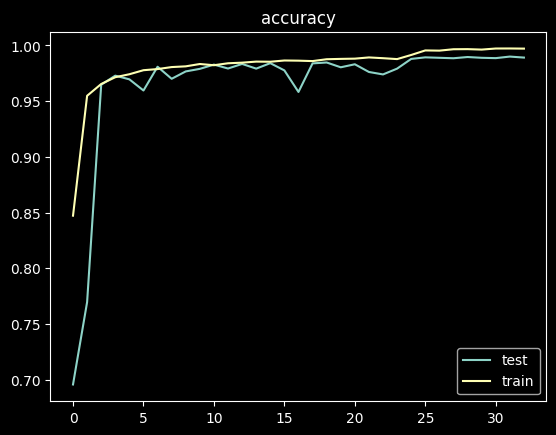

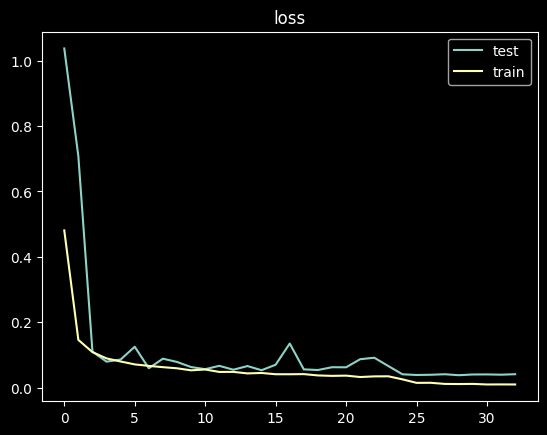

In [121]:
plot_metrics(history, "accuracy")
plt.show()
plot_metrics(history, "loss")

In [122]:
learning_rate = 0.005/100
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))

for i in range(3):
  model.train()
  for step, batch in tqdm(enumerate(train_ds.as_numpy_iterator()), total=train_steps):
    train_step(model, optimizer, metrics, batch)
    if step % eval_every == 0 and step > 0:
      log_metrics(history, metrics, step)

 25%|██▌       | 505/2000 [00:44<10:31,  2.37it/s]

[train:500] loss 0.0077971853 accuracy 99.773445 %
[test:500] loss 0.040504806 accuracy 98.94832 %


 50%|█████     | 1004/2000 [01:22<08:04,  2.05it/s]

[train:1000] loss 0.006582318 accuracy 99.82188 %
[test:1000] loss 0.040370177 accuracy 98.96835 %


 75%|███████▌  | 1504/2000 [02:03<09:29,  1.15s/it]

[train:1500] loss 0.007553931 accuracy 99.787506 %
[test:1500] loss 0.04033887 accuracy 98.98838 %


 25%|██▌       | 503/2000 [00:38<14:09,  1.76it/s]

[train:500] loss 0.0063268687 accuracy 99.839066 %
[test:500] loss 0.040035807 accuracy 98.98838 %


 50%|█████     | 1003/2000 [01:13<07:46,  2.13it/s]

[train:1000] loss 0.0066108727 accuracy 99.818756 %
[test:1000] loss 0.040321965 accuracy 98.97836 %


 75%|███████▌  | 1503/2000 [01:51<04:09,  2.00it/s]

[train:1500] loss 0.006917794 accuracy 99.81251 %
[test:1500] loss 0.040483657 accuracy 98.97836 %


 25%|██▌       | 504/2000 [00:41<24:18,  1.03it/s]

[train:500] loss 0.006393932 accuracy 99.83282 %
[test:500] loss 0.04020906 accuracy 99.008415 %


 50%|█████     | 1003/2000 [01:18<07:54,  2.10it/s]

[train:1000] loss 0.0061829546 accuracy 99.83125 %
[test:1000] loss 0.0402574 accuracy 98.958336 %


 75%|███████▌  | 1505/2000 [01:55<04:17,  1.92it/s]

[train:1500] loss 0.0069889706 accuracy 99.79688 %
[test:1500] loss 0.040476616 accuracy 98.98838 %


100%|██████████| 2000/2000 [02:24<00:00, 13.79it/s]


In [124]:
@nnx.jit
def predict(model, batch):
  logits = model(batch)
  probs = nnx.softmax(logits, axis=-1)
  return jnp.argmax(probs, axis=-1), probs



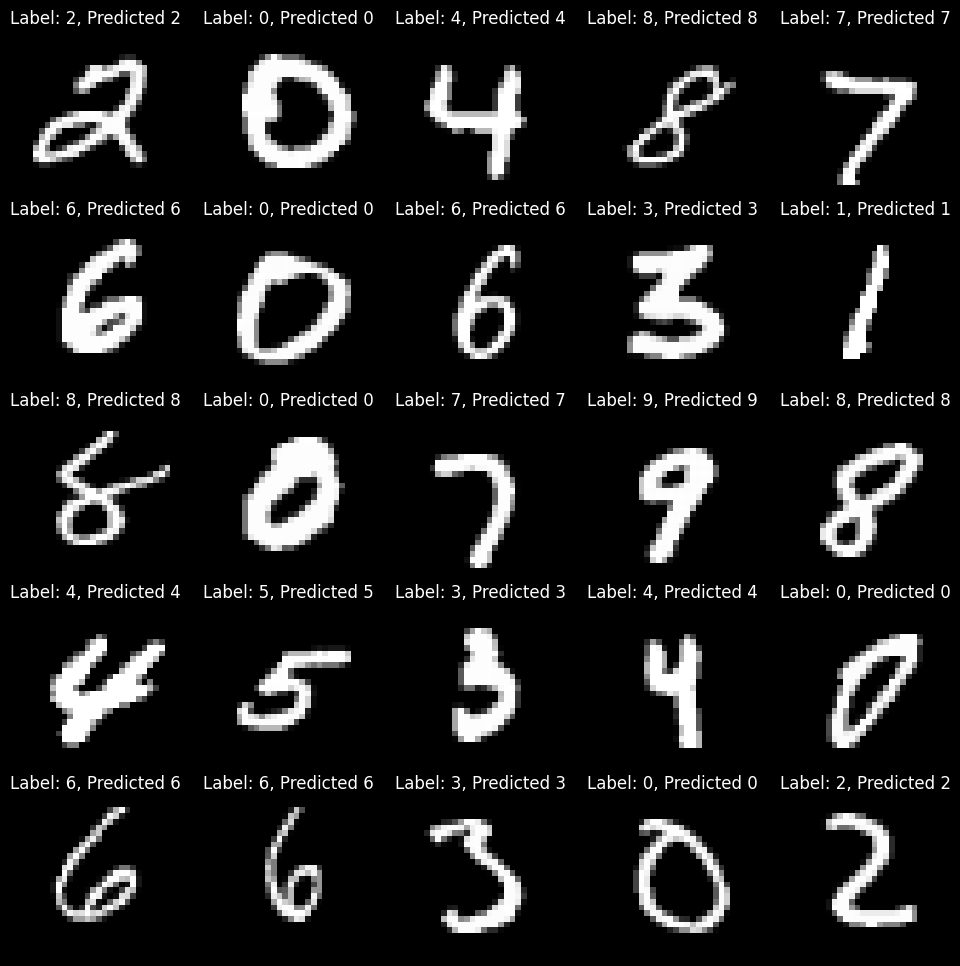

In [127]:
def view_batch_preds(model, batch, rows=5, cols=5):
  fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
  preds, _ = predict(model, batch["image"])
  for i, ax in enumerate(axs.flat):
    ax.imshow(batch["image"][i], cmap="gray")
    ax.set_title(f"Label: {batch['label'][i]}, Predicted {preds[i]}")
    ax.axis('off')
view_batch_preds(model, test_ds.as_numpy_iterator().next(), rows=5, cols=5)